### 패키지 임포트

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join
from sklearn.model_selection import train_test_split

# 분석
import pandas as pd
import numpy as np
import missingno as msno
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

# 모델
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

# 시각화
import matplotlib.pyplot as plt
import seaborn as sns

### 데이터 불러오기

In [53]:
# 파일 불러오기
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv')

data = pd.read_csv(train_data_path)
test= pd.read_csv(test_data_path)

print(f'train data shape {data.shape}')
print(f'test data shape {test.shape}')

train data shape (15035, 21)
test data shape (6468, 20)


### 각 컬럼별 최대 최소를 알아보자

In [56]:
min_max_df = pd.DataFrame(columns=["min", "max"])
for i, index in enumerate(data.keys()):
    min_max_df.loc[index] = [data[index].min(), data[index].max()]

min_max_df

,min,max
id,0,15034
date,20140502T000000,20150514T000000
price,78000.0,7700000.0
bedrooms,0,10
bathrooms,0.0,8.0
sqft_living,290,13540
sqft_lot,520,1651359
floors,1.0,3.5
waterfront,0,1
view,0,4


### 각 컬럼별 unique한 값은 몇개일까?
- unique가 적은 컬럼은 카테고리형 변수, 많은건 연속형 변수라고 볼수 있다.

In [57]:
colunms_uni = {}
for index in data.keys():
    colunms_uni[index] = len(data[index].unique())
    
colunms_uni

{'id': 15035,
 'date': 365,
 'price': 3263,
 'bedrooms': 11,
 'bathrooms': 29,
 'sqft_living': 863,
 'sqft_lot': 7678,
 'floors': 6,
 'waterfront': 2,
 'view': 5,
 'condition': 5,
 'grade': 12,
 'sqft_above': 789,
 'sqft_basement': 271,
 'yr_built': 116,
 'yr_renovated': 65,
 'zipcode': 70,
 'lat': 4692,
 'long': 716,
 'sqft_living15': 682,
 'sqft_lot15': 6958}

### 가격과 컬럼간 상관계수를 알아보자

In [58]:
data.corr()['price']

id               0.020899
price            1.000000
bedrooms         0.323672
bathrooms        0.525479
sqft_living      0.702899
sqft_lot         0.096793
floors           0.262588
waterfront       0.265738
view             0.400806
condition        0.039740
grade            0.667211
sqft_above       0.608577
sqft_basement    0.322218
yr_built         0.047290
yr_renovated     0.140808
zipcode         -0.051498
lat              0.301604
long             0.023547
sqft_living15    0.586419
sqft_lot15       0.086384
Name: price, dtype: float64

<AxesSubplot:>

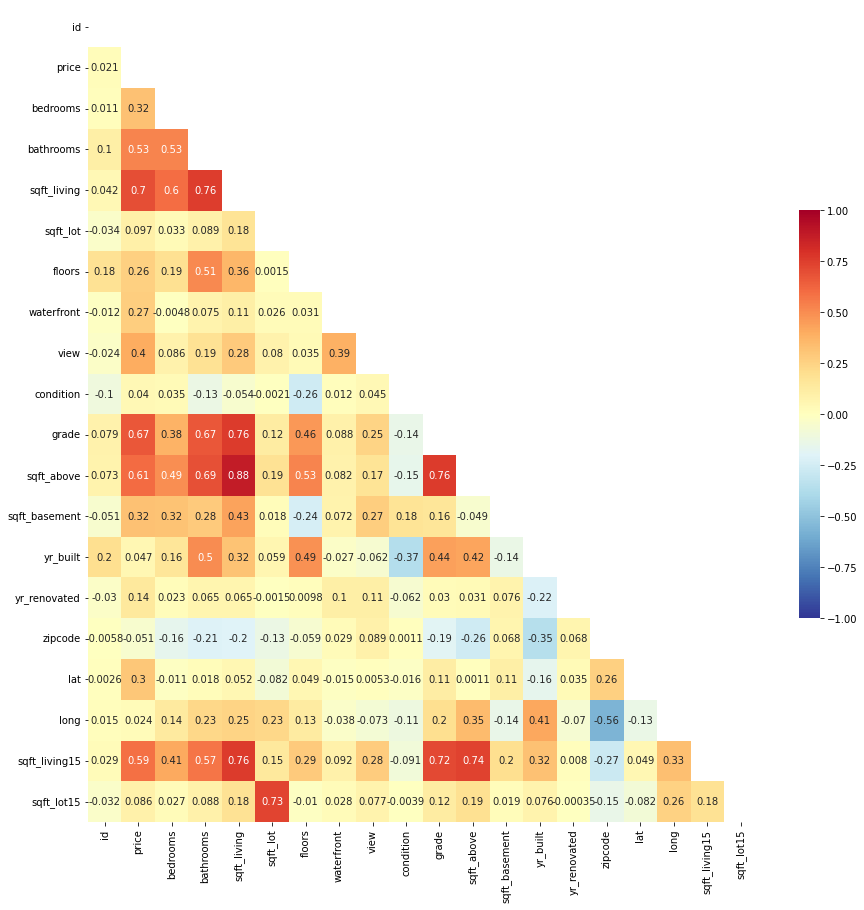

In [59]:
df = data.corr()

plt.figure(figsize = (15,15)) # 사이즈 조절

# 삼각형으로 보기
mask = np.zeros_like(df, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(df, 
               annot = True,      # 실제 값 화면에 나타내기
               cmap = 'RdYlBu_r',  # Red, Yellow, Blue 색상으로 표시
               mask=mask,
               cbar_kws={"shrink": .5},# 컬러바 크기 절반으로 줄이기
               vmin = -1, vmax = 1, #컬러차트 -1 ~ 1 범위로 표시
              )

### 가격과 상관 관계가 높은 top10

In [60]:
df_largest_10 = data.corr()['price'].nlargest(n=11)
df_largest_10

price            1.000000
sqft_living      0.702899
grade            0.667211
sqft_above       0.608577
sqft_living15    0.586419
bathrooms        0.525479
view             0.400806
bedrooms         0.323672
sqft_basement    0.322218
lat              0.301604
waterfront       0.265738
Name: price, dtype: float64

### 그래프로 확인

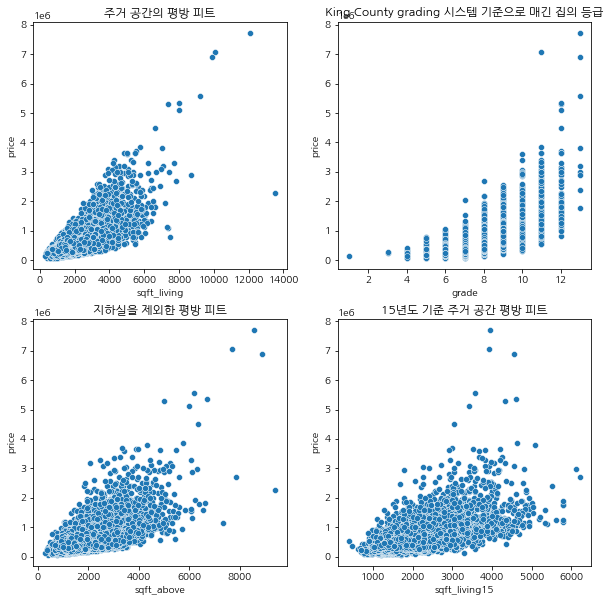

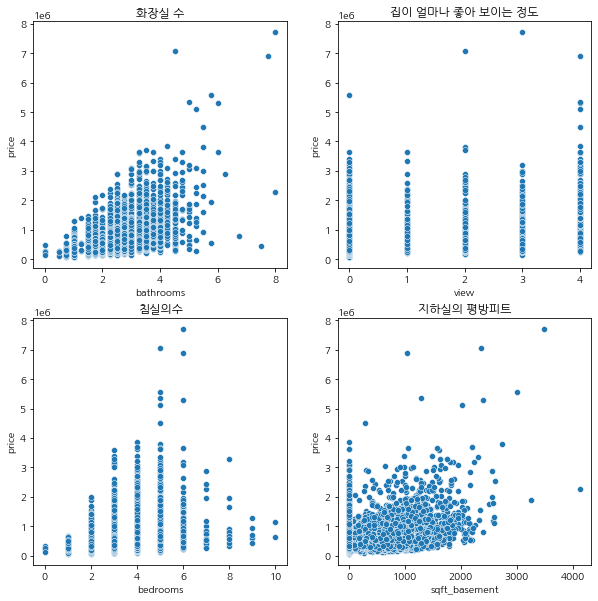

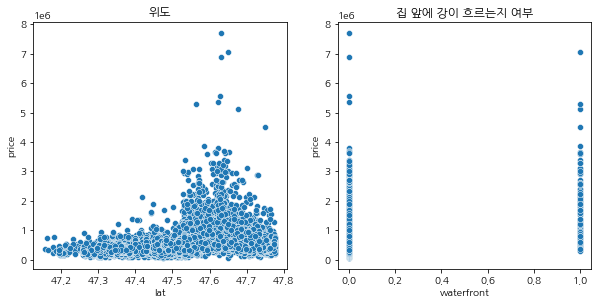

In [61]:
plt.rcParams['font.family'] = 'NanumGothic'

fig1 = plt.figure(figsize=(10,10))

ax1 = fig1.add_subplot(2,2,1)
p1= sns.scatterplot(data=data, x='sqft_living', y='price')
p1.set_title("주거 공간의 평방 피트")

ax2 = fig1.add_subplot(2,2,2)
p2 = sns.scatterplot(data=data, x='grade', y='price')
p2.set_title("King County grading 시스템 기준으로 매긴 집의 등급")

ax3 = fig1.add_subplot(2,2,3)
p3 = sns.scatterplot(data=data, x='sqft_above', y='price')
p3.set_title("지하실을 제외한 평방 피트")

ax4 = fig1.add_subplot(2,2,4)
p4 = sns.scatterplot(data=data, x='sqft_living15', y='price')
p4.set_title("15년도 기준 주거 공간 평방 피트")

fig2 = plt.figure(figsize=(10,10))

ax5 = fig2.add_subplot(2,2,1)
p5 = sns.scatterplot(data=data, x='bathrooms', y='price')
p5.set_title("화장실 수")

ax6 = fig2.add_subplot(2,2,2)
p6 = sns.scatterplot(data=data, x='view', y='price')
p6.set_title("집이 얼마나 좋아 보이는 정도")

ax7 = fig2.add_subplot(2,2,3)
p7 = sns.scatterplot(data=data, x='bedrooms', y='price')
p7.set_title("침실의수")

ax8 = fig2.add_subplot(2,2,4)
p8 = sns.scatterplot(data=data, x='sqft_basement', y='price')
p8.set_title("지하실의 평방피트")

fig3 = plt.figure(figsize=(10,10))

ax9 = fig3.add_subplot(2,2,1)
p9 = sns.scatterplot(data=data, x='lat', y='price')
p9.set_title("위도")

ax9 = fig3.add_subplot(2,2,2)
p9 = sns.scatterplot(data=data, x='waterfront', y='price')
p9.set_title("집 앞에 강이 흐르는지 여부")

plt.show()

상관 관계를 통해서 데이터를 가공해야 할것 같다.

## 이번 루브릭 목표
- 데이터 전처리, 모델학습, 예측의 전체 과정을 거쳐 캐글 submisson까지 전과정이 성공적으로 진행 되었는가?  
- 제출된 노트북이 캐글 커널로 사용될 수 있을만큼 전처리, 학습, 최적화진행 과정이 체계적으로 기술되었는가?  
- 다양한 피처 엔지니어링과 하이퍼 파라미터 튜닝 등의 최적화 기법을 통해 캐글 리더보드의 socre 기준으로 11000 점 이하의 점수를 얻었는가?  

### price 컬럼 삭제 및 전처리를 위한 데이터 합치기

In [10]:
y = data['price']
del data['price']

train_len = len(data)
data = pd.concat((data, test), axis=0)

### 결측치 확인

In [11]:
for index in data.keys():
    print(f'{index} null count : {len(data.loc[pd.isnull(data[index]), index].values)}')

id null count : 0
date null count : 0
bedrooms null count : 0
bathrooms null count : 0
sqft_living null count : 0
sqft_lot null count : 0
floors null count : 0
waterfront null count : 0
view null count : 0
condition null count : 0
grade null count : 0
sqft_above null count : 0
sqft_basement null count : 0
yr_built null count : 0
yr_renovated null count : 0
zipcode null count : 0
lat null count : 0
long null count : 0
sqft_living15 null count : 0
sqft_lot15 null count : 0


### 예측에 필요없는 id 행과, date 컬럼 연,월,일로 정리

In [12]:
sub_id = data['id'][train_len:]
del data['id']

In [13]:
data['date'] = data['date'].apply(lambda x : int(x[:6]))

### 각 컬럼별 분포 확인

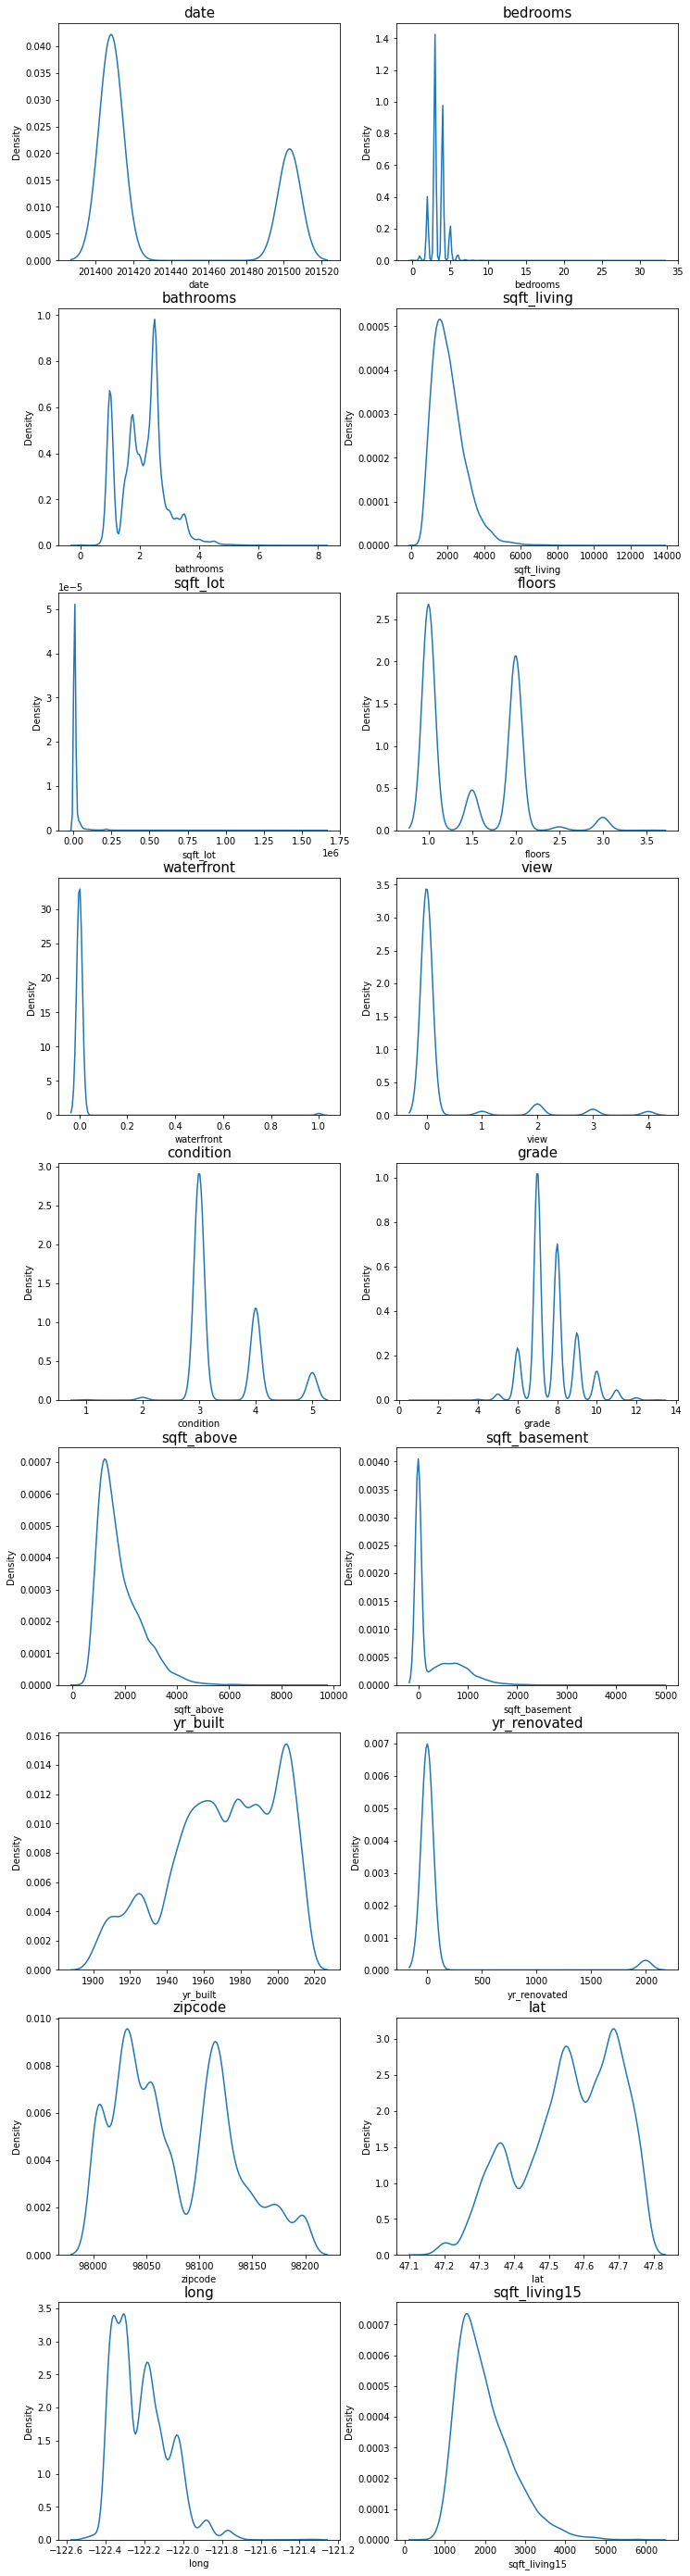

In [24]:
fig, ax = plt.subplots(9, 2, figsize=(12, 50))   # 가로스크롤 때문에 그래프 확인이 불편하다면 figsize의 x값을 조절해 보세요. 

# id 변수(count==0인 경우)는 제외하고 분포를 확인합니다.
count = 0
columns = data.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(data=data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19 :
            break

### 전처리가 끝났으니 다시 train과 test 셋으로 분리

In [14]:
train = data.iloc[:train_len, :]
test = data.iloc[train_len:, :]

print(train.shape)
print(test.shape)

(15035, 19)
(6468, 19)


### y 데이터 확인 및 log화

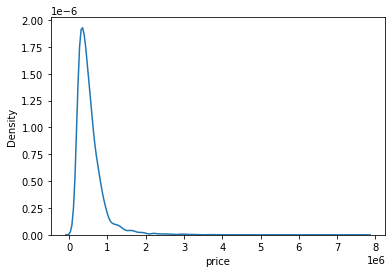

In [15]:
sns.kdeplot(y)
plt.show()

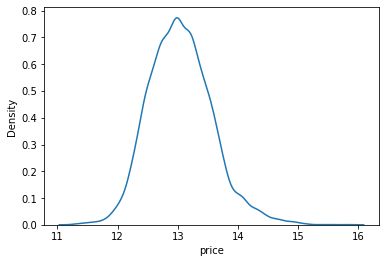

In [16]:
y = np.log1p(y)

sns.kdeplot(y)
plt.show()

### 모델 파라미터 찾기 (GridSearch)

In [17]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    
    grid_model = GridSearchCV(model, param_grid=param_grid, \
                              scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    grid_model.fit(train,y)
    
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    results = pd.DataFrame(params)
    results['score'] = score
    
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values(by=['RMSLE'])
    
    return results

### LGBM 파라미터들
- learning_rate : 0 ~ 1 사이 값
- n_estimators : 반복 수행하는 트리의 개수, 너무 크게 지정하면 학습시간이 오래걸리고 과적합이 발생
- max_depth : 트리의 최대 깊이 
- num_leaves : 하나의 트리가 가질 수 있는 최대 리프 개수, max_depth^2 의 수보다 적어야한다.
- min_child_samples : 최종 결정 클래스인 leaf node가 되기 위해 최소한으로 필요한 데이터 개체수, 과적합 제어
- subsample : 과적합을 제어하기 위한 데이터를 샘플링 하는 비율을 의미한다.

In [18]:
param_grid = {
    'n_estimators': [50, 100, 150 , 200],
    'max_depth': [10, 15, 20],
    'min_child_samples': [10, 20, 30, 40],
    'subsample':[0.8,1]
}

random_state = 2022

In [33]:
model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=1, n_jobs=5)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


,max_depth,min_child_samples,n_estimators,subsample,score,RMSLE
23,10,30,200,1.0,-0.026130,0.161648
22,10,30,200,0.8,-0.026130,0.161648
15,10,20,200,1.0,-0.026188,0.161828
14,10,20,200,0.8,-0.026188,0.161828
79,20,20,200,1.0,-0.026245,0.162003
...,...,...,...,...,...,...
64,20,10,50,0.8,-0.029321,0.171234
1,10,10,50,1.0,-0.029381,0.171408
0,10,10,50,0.8,-0.029381,0.171408
25,10,40,50,1.0,-0.029447,0.171600


### GridSearch로 찾은 파라미터로 모델 정의하기

In [20]:
model = LGBMRegressor(max_depth=10, min_child_samples = 30, n_estimators=200, subsample = 1, random_state=random_state)

### 예측결과 저장하기

In [46]:
def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [22]:
save_submission(model, train, y, test, 'lgbm', rmsle='0.1616')

/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.1616.csv saved!


### LGBM제출결과

![no Image](./EX5result/LGBM.jpg)

### 같은 파라미터로 Xgboost 모델만 바꿔보기

In [27]:
param_grid2 = {
    'n_estimators': [50, 100, 150],
    'max_depth': [10, 15],
    'min_child_samples': [1, 5, 10]
}

In [ ]:
model2 = XGBRegressor(random_state=random_state)
my_GridSearch(model2, train, y, param_grid2, verbose=1, n_jobs=5)

In [44]:
model2 = XGBRegressor(max_depth=10, min_child_samples = 30, n_estimators=150, learning_rate=0.05, random_state=random_state)

In [47]:
save_submission(model, train, y, test, 'xgbr', rmsle='0.1616')

/aiffel/aiffel/kaggle_kakr_housing/data/submission_xgbr_RMSLE_0.1616.csv saved!


### XGB 결과

![no Image](./EX5result/XGB.jpg)

### save_submisson 함수 쪼개기

In [37]:
def model_fit(model, train, y, test):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    
    return prediction

def save_submission2(prediction, model_name, rmsle=None):
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

### 결과 Asemble
두 모델의 예측값을 vstack 을 이용해 평균 내서 제출해봤다.

In [49]:
lgb_pred = model_fit(model, train, y, test)
xgb_pred = model_fit(model2, train, y, test)

[12:59:53] WARNING: ../src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [50]:
ensemble_pred = np.vstack([lgb_pred, xgb_pred]).mean(0)

In [51]:
save_submission2(ensemble_pred, 'asemble', rmsle='0.1616')

/aiffel/aiffel/kaggle_kakr_housing/data/submission_asemble_RMSLE_0.1616.csv saved!


![no Image](./EX5result/ASEMBLE.jpg)

## 회고

- 이번 Exploration을 진행하면서 kaggle 이란 사이트를 알게 되었다.  
피처 엔지니어링부터 하이퍼 파라미터 튜닝을 통해 모델을 학습시키고 결과를 제출해 스코어 경쟁을 하는 사이트이다.  
- 이전에는 하이퍼 파라미터를 수작업으로 고치고, 학습하고를 반복했었는데 이번에 GridSearch라는 패키지를 알게 되었다.  
내가 원하는 하이퍼 파라미터의 조합을 통해서 최적의 성능을 찾아내는 함수였다.  
덕분에 수작업으로 몇번 했어야하는 일을 자동으로 할 수 있어서 앞으로도 잘 사용할듯 하다.

### 아쉬웠던점
- 프로젝트를 진행하다가 LGBMRegressor -> XGBRegressor 모델로 바꾸면서 gridsearch가 작동이 안됐다.  
그래서 적당한 하이퍼 파라미터 값으로 넣고 진행했던 점이 아쉬웠다.
- 그러다보니 루브릭 평가 지표를 넘기기에 모델의 값이 정확하지 않아서 아쉽게 넘지는 못했다.  

### 이후 해보고 싶은사항들
- 다른 사람들이 제출한 노드들을 살펴보니 하이퍼 파라미터 튜닝도 튜닝이지만 피처 엔지니어링 부분이 대단했다.  
- zipcode와 위도 경도를 계산해 비싼 지역을 추출해 계산을 한다던가 주어진 피처만 가지고 학습을 하는게 아니라 새로운 컬럼을 생성해 학습을 시킨사람들이 대부분이였다.  
자주 이런 기회를 접해서 이런 생각들을 키워나가고 싶다.
- 이번 exploration에서는 모델을 2개를 사용하고, 결과값을 asemble 햇는데, 다양한 모델들을 asemble 하고 싶다.
- 앞서 상관관계에 따른 컬럼별을 가공해서 피처 엔지니어링을 해보고 싶다.